In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

# Data Setup & Functions

In [3]:
from mll_calc.mll_pred import format_XY

In [4]:
def logpdf_calc(row, test_sample, unc):
    y_sim = row[test_sample>0].values.tolist()
    std = row.multiply(unc)[test_sample>0].values.tolist()
    y_mes = test_sample[test_sample>0].values.tolist()
    logpdf_list = stats.norm.logpdf(y_sim, loc=y_mes, scale=std)
    return logpdf_list

In [5]:
def loop_sfco(XY, test, pred, unc, lbls, nonlbls):
    logpdf_df = pd.DataFrame()
    for test_idx, row in test.iterrows():
        test_sample = row.drop(lbls)
        test_answer = row[lbls]
        
        pred_idx = pred['pred_idx'].loc[pred['sim_idx'] == test_idx]
        train_row = XY.loc[pred_idx.values[0]].drop(lbls+nonlbls)
        
        logpdf = logpdf_calc(train_row, test_sample, unc)
        logpdf = pd.Series(logpdf, index=train_row[test_sample>0].index, name=test_idx)
        
        #Check match
        pred['MaxLogLL'].loc[sfcoLL['sim_idx']==good_id]
        
        if logpdf_df.empty:
            logpdf_df = pd.DataFrame(columns = test_sample.index.to_list())
        logpdf_df = logpdf_df.append(logpdf)
    return logpdf_df

### Train and Test DBs

In [6]:
train_pkl = '~/sims_n_results/simupdates_aug2020/not-scaled_nuc15.pkl'
XY = format_XY(train_pkl)

sfco_pkl = '~/sfcompo/format_clean/sfcompo_nuc15.pkl'
sfco = pd.read_pickle(sfco_pkl)

### LL Calc Results

In [7]:
sfcompo_results = '~/sims_n_results/simupdates_aug2020/sfco15/'

uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]
dfs = {}
for i, unc_job in enumerate(job_dirs):
    dfs['unc' + str(i)] = pd.read_csv(sfcompo_results + unc_job + '/' + unc_job + '.csv')

for dfname in list(dfs.keys()):
    df = dfs[dfname]
    df['Relative_Burnup_Error'] = df['Burnup_Error'] / df['Burnup']

# For ease of only viewing 5% case for now
preds = dfs['unc0']

### LogPDF (wrt nuclide) results

In [8]:
unc = 0.05
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
nonlbls = ['AvgPowerDensity', 'ModDensity', 'UiWeight']
logpdf_df = loop_sfco(XY, sfco, preds, unc, lbls, nonlbls)

# Explore Errors

### Burnup

In [9]:
preds['Relative_Burnup_Error'].describe()
#old results for reference:
#count    544.000000
#mean       0.332184
#std        0.285241
#min        0.000074
#25%        0.193478
#50%        0.297102
#75%        0.393373
#max        2.743641

count    505.000000
mean       0.187539
std        0.155398
min        0.000408
25%        0.058485
50%        0.153846
75%        0.298556
max        1.503097
Name: Relative_Burnup_Error, dtype: float64

In [10]:
to_print = ['sim_idx', 'pred_idx', 'pred_CoolingTime', 'AvgPowerDensity', 
            'ReactorType', 'pred_ReactorType', 'ReactorType_Score', 
            'Enrichment', 'pred_Enrichment', 'Enrichment_Error', 
            'Burnup', 'pred_Burnup', 'Relative_Burnup_Error',
            'OrigenReactor', 'pred_OrigenReactor', 'MaxLogLL']
preds.loc[preds['Relative_Burnup_Error'] > 0.49, to_print]

,sim_idx,pred_idx,pred_CoolingTime,AvgPowerDensity,ReactorType,pred_ReactorType,ReactorType_Score,Enrichment,pred_Enrichment,Enrichment_Error,Burnup,pred_Burnup,Relative_Burnup_Error,OrigenReactor,pred_OrigenReactor,MaxLogLL
24,FDN-1|2F1ZN2|C3|UB,312854,1083.936839,41.0,bwr,pwr,False,4.900,0.51,4.390,47490.0,18330.69,0.614009,Fukushima-Daini-1_BWR,bw15x15,-9.539628
38,FDN-2|2F2D3|H5|TU302,244758,1407.176700,41.0,bwr,pwr,False,3.400,0.51,2.890,31400.0,15867.31,0.494672,Fukushima-Daini-2_BWR,ce14x14,0.743836
39,FDN-2|2F2D3|A4|TU306,287604,2011.587621,25.0,bwr,pwr,False,3.400,0.50,2.900,32300.0,16206.28,0.498258,Fukushima-Daini-2_BWR,s18x18,-0.007534
49,FDN-2|2F2D8|H5|TU503,187444,21.396677,10.0,bwr,bwr,True,3.400,0.50,2.900,55600.0,27569.97,0.504137,Fukushima-Daini-2_BWR,svea64-1,5.905322
54,GAR-1|SA-13|E6|11,114548,464.008668,25.0,bwr,bwr,True,2.410,5.23,2.820,4200.0,7656.06,0.822871,Garigliano-1_BWR,abb8x8-1,16.508729
55,GAR-1|SA-13|E6|13,171792,812.044584,10.0,bwr,bwr,True,2.410,5.11,2.700,5580.0,9700.27,0.738400,Garigliano-1_BWR,atrium10x10-9,14.079438
64,GAR-1|A-106|C3|1,166978,7097.519283,10.0,bwr,bwr,True,2.100,4.23,2.130,9140.0,14697.28,0.608018,Garigliano-1_BWR,atrium10x10-9,-112.530928
202,NOV-4|213|25|9,290040,0.000776,41.0,pwr,pwr,True,3.600,0.50,3.100,27600.0,11834.22,0.571224,Novovoronezh-4_VVER-440,s18x18,-28.451755
236,NPD-1|1022|A|1,30358,6973.335475,10.0,phwr,bwr,False,0.711,2.74,2.029,791.0,1979.95,1.503097,Nuclear Power Demonstration Reactor-1_CANDU,ge7x7-0,-24.645155
284,OBR-1|BE210|G14|P5(1),241572,854.157139,25.0,pwr,bwr,False,2.830,5.05,2.220,30100.0,45382.93,0.507739,Obrigheim-1_PWR,svea64-1,-20.559729


### Enrichment

In [11]:
preds['Enrichment_Error'].describe()
#old results for reference:
#count    544.000000
#mean       1.822317
#std        1.079040
#min        0.000000
#25%        0.940000
#50%        1.870000
#75%        2.590000
#max        4.400000

count    505.000000
mean       1.103471
std        0.814116
min        0.000000
25%        0.465000
50%        0.961000
75%        1.770000
max        4.400000
Name: Enrichment_Error, dtype: float64

In [12]:
preds.loc[preds['Enrichment_Error'] > 2.5, to_print]

,sim_idx,pred_idx,pred_CoolingTime,AvgPowerDensity,ReactorType,pred_ReactorType,ReactorType_Score,Enrichment,pred_Enrichment,Enrichment_Error,Burnup,pred_Burnup,Relative_Burnup_Error,OrigenReactor,pred_OrigenReactor,MaxLogLL
16,COO-1|CZ346|ADD2974|J,307073,6067.268722,25.0,bwr,pwr,False,2.94,5.48,2.54,29230.0,41063.62,0.404845,Cooper-1_BWR,s18x18,-42.394934
24,FDN-1|2F1ZN2|C3|UB,312854,1083.936839,41.0,bwr,pwr,False,4.90,0.51,4.39,47490.0,18330.69,0.614009,Fukushima-Daini-1_BWR,bw15x15,-9.539628
26,FDN-1|2F1ZN3|C3|UT,295761,1666.272340,25.0,bwr,pwr,False,4.90,2.15,2.75,59050.0,45319.61,0.232521,Fukushima-Daini-1_BWR,s18x18,-23.887804
29,FDN-1|2F1ZN3|C3|UB,1205,84.338574,10.0,bwr,bwr,True,4.90,0.50,4.40,68250.0,36458.87,0.465804,Fukushima-Daini-1_BWR,ge7x7-0,1.116023
30,FDN-1|2F1ZN3|C3|UM,250710,2566.433822,25.0,bwr,pwr,False,4.90,2.19,2.71,68420.0,70500.00,0.030400,Fukushima-Daini-1_BWR,ce14x14,-3.236639
38,FDN-2|2F2D3|H5|TU302,244758,1407.176700,41.0,bwr,pwr,False,3.40,0.51,2.89,31400.0,15867.31,0.494672,Fukushima-Daini-2_BWR,ce14x14,0.743836
39,FDN-2|2F2D3|A4|TU306,287604,2011.587621,25.0,bwr,pwr,False,3.40,0.50,2.90,32300.0,16206.28,0.498258,Fukushima-Daini-2_BWR,s18x18,-0.007534
49,FDN-2|2F2D8|H5|TU503,187444,21.396677,10.0,bwr,bwr,True,3.40,0.50,2.90,55600.0,27569.97,0.504137,Fukushima-Daini-2_BWR,svea64-1,5.905322
50,FDN-2|2F2D8|A4|TU506,1149,473.850856,10.0,bwr,bwr,True,3.40,0.50,2.90,57500.0,34140.74,0.406248,Fukushima-Daini-2_BWR,ge7x7-0,1.177680
52,FDN-2|2F2D8|H5|TU502,288008,378.041108,25.0,bwr,pwr,False,3.40,0.50,2.90,58900.0,33814.22,0.425905,Fukushima-Daini-2_BWR,s18x18,-3.204798


# Max Log LL

In [23]:
print(dfs['unc0']['MaxLogLL'].describe())
print(dfs['unc3']['MaxLogLL'].describe())

count    505.000000
mean     -12.379540
std       46.738361
min     -438.446156
25%      -12.343408
50%       -4.528192
75%        6.085927
max       52.071185
Name: MaxLogLL, dtype: float64
count    505.000000
mean       6.654287
std        9.238379
min       -5.505686
25%       -0.227195
50%        2.738450
75%       11.888770
max       43.619047
Name: MaxLogLL, dtype: float64


# Nuclide Contributions to LL

In [13]:
nuc15 = ['cs133', 'cs134', 'cs135', 'cs137', 
         'eu153', 'eu154', 'ba136', 'ba138', 
         'sm149', 'sm150', 'sm152', 
         'pu239', 'pu240', 'pu241', 'pu242']

In [14]:
logpdf_df.sample(10)

,cs133,cs134,cs135,cs137,eu153,eu154,ba136,ba138,sm149,sm150,sm152,pu239,pu240,pu241,pu242
NPD-1|1022|A|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-204.534493,-201.501455,-198.225595,-195.139266
FDN-2|2F2D1|F6|TU101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-205.806282,-203.915152,-203.147786,-200.928546
TMI-1|NJ05YU|H6|A2,NaN,NaN,NaN,-204.785643,-202.616050,NaN,NaN,NaN,-10.444557,-202.652355,-199.859732,-206.553455,-205.610205,-205.195585,-202.814850
VAN-2|EF05|WZR0058|E58-263,-205.086832,-203.261975,-204.43227,-205.315365,-202.895124,-201.782033,NaN,NaN,0.434673,-203.138244,-199.474133,-206.628994,-205.720036,-205.539475,-203.749684
TMI-1|NJ070G|O12|S6,NaN,-200.623454,NaN,-204.297820,-201.819420,NaN,NaN,NaN,-80.904829,-201.754255,-201.579445,-206.517958,-204.889688,-204.616470,-188.302208
TVC-1|509-069|E11|2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-206.133657,-204.553646,-204.317549,-202.848286
OBR-1|BE124|G7|P3,NaN,NaN,NaN,-204.812007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-206.283733,-205.016005,-204.724265,-204.219445
TMI-1|NJ05YU|H6|C2B,NaN,NaN,NaN,-204.849853,-202.693295,NaN,NaN,NaN,-4.860783,-202.795232,-200.130970,-206.485315,-205.537275,-205.078998,-202.946645
HBR-2|BO-5|P8|A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-206.180154,-204.779416,-204.376229,-203.481001
FDN-1|2F1ZN2|C3|UB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-205.764514,-204.977933,-204.381806,-204.054764


### Pu 

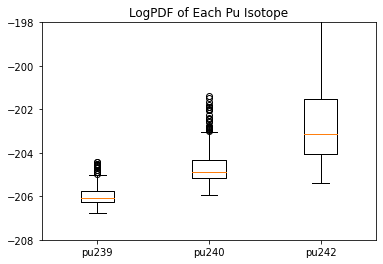

In [15]:
pu = [logpdf_df['pu239'],
      logpdf_df['pu240'],
      #logpdf_df['pu241'],
      logpdf_df['pu242']
     ]
fig, ax = plt.subplots()
ax.set_title('LogPDF of Each Pu Isotope')
ax.boxplot(pu, labels=['pu239', 'pu240', 'pu242'])
ax.set_ylim(-208, -198)
plt.show()

In [16]:
print(logpdf_df['pu239'].describe())
print(logpdf_df['pu240'].describe())
print(logpdf_df['pu241'].describe())
print(logpdf_df['pu242'].describe())

count    505.000000
mean    -205.966367
std        0.461087
min     -206.769732
25%     -206.251894
50%     -206.066292
75%     -205.748481
max     -204.411418
Name: pu239, dtype: float64
count    505.000000
mean    -204.663664
std        0.814477
min     -205.949509
25%     -205.141864
50%     -204.866166
75%     -204.308321
max     -201.370247
Name: pu240, dtype: float64
count    504.000000
mean    -203.998881
std        1.245687
min     -205.634820
25%     -204.814967
50%     -204.464787
75%     -203.734081
max     -198.225595
Name: pu241, dtype: float64
count    505.000000
mean    -202.223429
std        3.395099
min     -205.371097
25%     -204.042128
50%     -203.119556
75%     -201.530555
max     -159.308178
Name: pu242, dtype: float64


### Cs

In [ ]:
cs = [logpdf_df['cs133'][logpdf_df['cs133'] != np.nan],
      logpdf_df['cs134'][logpdf_df['cs134'] != np.nan],
      logpdf_df['cs135'][logpdf_df['cs135'] != np.nan], 
      logpdf_df['cs137'][logpdf_df['cs137'] != np.nan]
      ]
fig, ax = plt.subplots()
ax.set_title('LogPDF of Each Cs Isotope')
ax.boxplot(cs, labels=['cs133', 'cs134', 'cs135', 'cs137'])
#ax.set_ylim(-40, 15)
plt.show()

In [17]:
print(logpdf_df['cs133'].describe())
print(logpdf_df['cs134'].describe())
print(logpdf_df['cs135'].describe())
print(logpdf_df['cs137'].describe())

count     46.000000
mean    -204.875603
std        0.252222
min     -205.437033
25%     -205.053244
50%     -204.890834
75%     -204.709785
max     -204.264470
Name: cs133, dtype: float64
count    113.000000
mean    -199.825565
std        1.954698
min     -203.412539
25%     -201.036583
50%     -200.255688
75%     -197.832664
max     -195.506944
Name: cs134, dtype: float64
count     40.000000
mean    -203.963063
std        0.288200
min     -204.456868
25%     -204.184356
50%     -203.957462
75%     -203.712241
max     -203.356849
Name: cs135, dtype: float64
count    185.000000
mean    -204.292555
std        0.834651
min     -205.315365
25%     -204.849853
50%     -204.586611
75%     -204.138321
max     -201.736804
Name: cs137, dtype: float64


### Eu

In [18]:
print(logpdf_df['eu153'].describe())
print(logpdf_df['eu154'].describe())

count     83.000000
mean    -202.610821
std        0.321034
min     -202.988418
25%     -202.853736
50%     -202.701024
75%     -202.509548
max     -201.740581
Name: eu153, dtype: float64
count    100.000000
mean    -199.504634
std        1.757175
min     -201.782033
25%     -200.826164
50%     -200.175082
75%     -197.539833
max     -194.903863
Name: eu154, dtype: float64


### Sm

In [19]:
print(logpdf_df['sm149'].describe())
print(logpdf_df['sm150'].describe())
print(logpdf_df['sm152'].describe())

count     97.000000
mean     -68.221233
std      111.787452
min     -474.464248
25%      -72.167335
50%      -23.738638
75%       -5.786952
max        2.437601
Name: sm149, dtype: float64
count     97.000000
mean    -202.736145
std        0.566972
min     -203.600947
25%     -203.236489
50%     -202.791600
75%     -202.388341
max     -200.223781
Name: sm150, dtype: float64
count     97.000000
mean    -200.106179
std        1.101751
min     -201.906898
25%     -200.976277
50%     -200.037505
75%     -199.375662
max     -197.498815
Name: sm152, dtype: float64
